Učitavanje potrebnih biblioteka

In [578]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2
import os
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

### Baza i analiza podataka

- Baza se sastoji iz 3 različite klase - prazan prostor, regularna loptica i loptica sa lošom konturom.      
- Pošto priložena baza nije labelirana, izdvojene su crne, braon i ljubičaste loptice, koje su manuelno pripisane odgovarajućim klasama. Ime labele prikačeno je nazivu slike i redni brojevi slika su reformisani. Ukupno ima 40 praznih slika, 166 regularnih i 108 slika neispravnih kuglica (ukupno 314 slika).     
- Ispod su prikazani primeri raznih klasa.

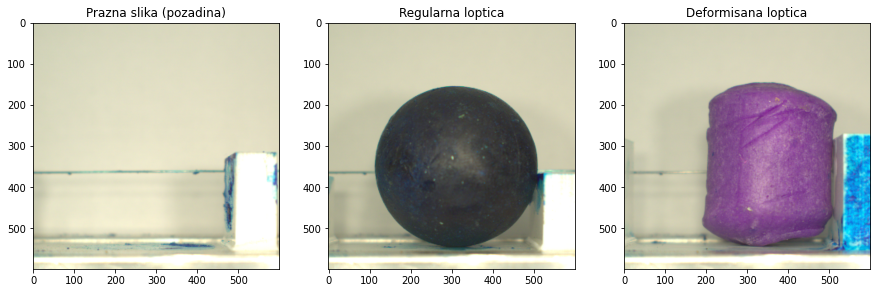

In [1869]:
slika_prazna = plt.imread('Kuglice\prazna (30).bmp')
slika_dobra = plt.imread('Kuglice\pune0 (2).bmp')
slika_losa = plt.imread('Kuglice\pune1 (259).bmp')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(slika_prazna)
plt.title('Prazna slika (pozadina)')
plt.subplot(1, 3, 2)
plt.imshow(slika_dobra)
plt.title('Regularna loptica')
plt.subplot(1, 3, 3)
plt.imshow(slika_losa) 
plt.title('Deformisana loptica')
plt.show()

### Izvlačenje karakteristike za klasifikaciju pozadine i loptice

Odnos srednje vrednosti pozadine slike i srednje vrednosti cele slike. 

In [1870]:
def feature_pozadina_loptica(image):

    # konverzija slike u grayscale
    slika = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # primena Gausovog filtra
    slika = cv2.GaussianBlur(slika, (13, 13), 30) 

    # odredjivanje pozadine slike   
    sub_image = slika[0:100, 0:100]

    mean_sub = np.mean(sub_image)   # srednja vrednost pozadine
    mean_pic = np.mean(slika)       # srednja vrednost cele slike

    # odnos srednje vrednosti pozadine i cele slike
    return mean_sub / mean_pic

Određivanje karakteristika svih slika.

In [1871]:
rootdir = 'C:/Users/Zephyrus/Marija/fakultet/4.7.PO/Kuglice' 
nema_kuglica, ima_kuglica = [], []      

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        label = file.split(' ')[-1]
        full_path = os.path.join(subdir, file)
        image = cv2.imread(full_path)
        if 'prazna' in full_path:
            nema_kuglica.append(feature_pozadina_loptica(image))
        else:
            ima_kuglica.append(feature_pozadina_loptica(image))

Prikaz histograma karakterisike odnosa srednje vrednosti piksela pozadine i cele slike.

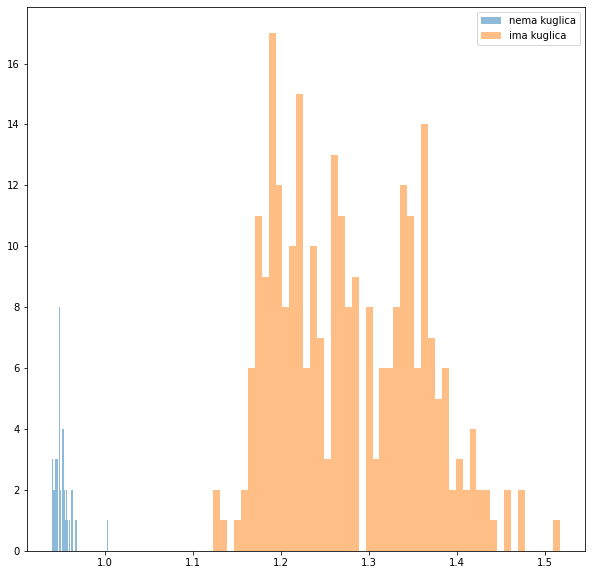

In [1872]:
plt.figure(figsize=(10, 10))
plt.hist(nema_kuglica, bins=50, alpha=0.5, label='nema kuglica')
plt.hist(ima_kuglica, bins=50, alpha=0.5, label='ima kuglica')
plt.legend(loc='upper right')
plt.show()

Na gornjem grafiku (histogramima) vidimo da su ove dve klase linearno separabilne. Za prazne slike, odnos srednje vrednosti poksela pozadine i srednje vrednosti piksela cele slike je vidno manji nego dati odnos kod pune slike. To se objašnjava pojavom loptice različite boje od pozadine, koja smanji prosek vrednosti piksela cele slike (loptica je tamnija od pozadine), i samim tim poveća vrednost odnosa (karakteristike).

### Klasifikacija na prazne i pune slike

In [1873]:
# kreiranje dataframe-a sa svim kuglicama i njihovim labelama
kuglice = pd.DataFrame({'feature1': nema_kuglica + ima_kuglica, 'label': [0] * len(nema_kuglica) + [1] * len(ima_kuglica)})

In [1875]:
# ukoliko je vrednost karakteristike manja od 1.01, slika ce biti klasifikovana kao prazna, u suprotnom kao puna
kuglice['predicted'] = kuglice['feature1'].apply(lambda x: 0 if x < 1.01 else 1)

Tačnost klasifikacije

In [1878]:
print('Accuracy: ', sum(kuglice['label'] == kuglice['predicted']) / len(kuglice))

Accuracy:  1.0


Prikaz matrice konfuzije 

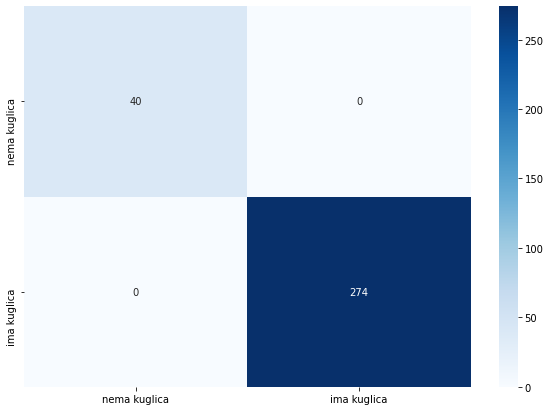

In [1879]:
cm = confusion_matrix(kuglice['label'], kuglice['predicted'])
df_cm = pd.DataFrame(cm, index=['nema kuglica', 'ima kuglica'], columns=['nema kuglica', 'ima kuglica'])

plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Iako su dati setovi nebalansirani, izvučena karakteristika omogućava vidnu separabilnost klasa, tako da problematika postaje trivijalna. Vidimo da ne postoji greška prilikom klasifikacije, tj. da su svi odbirci dobro klasifikovani.

### Slike sa regularnim i deformisanim kuglicama - analiza i pomoćne funkcije

Učitavanje svih slika i njihovih labela

In [1884]:
rootdir = 'C:/Users/Zephyrus/Marija/fakultet/4.7.PO/Kuglice' 
nema_kuglica, ima_kuglica = [], []     
ima_kuglica_labele = []      
redni_broj = []                                            

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        label = file.split(' ')[-2]
        full_path = os.path.join(subdir, file)

        slika = plt.imread(full_path)

        if label == 'prazna':
            nema_kuglica.append(slika)
        else:
            ima_kuglica.append(slika)
            redni_broj.append(int(file.split(' ')[-1][1:-5]))
            if label[-1] == '0':
                ima_kuglica_labele.append(0)
            else:
                ima_kuglica_labele.append(1)

Provera broja odbiraka

In [1885]:
len(ima_kuglica_labele), len(ima_kuglica), len(redni_broj)

(274, 274, 274)

Sortiranje kuglica prema rednim brojevima radi lakšeg izvlačenja pojedinačnih primera iz baze, vizualizacije i analize karakteristika

In [1886]:
ima_kuglica = [x for _, x in sorted(zip(redni_broj, ima_kuglica))]
ima_kuglica_labele = [x for _, x in sorted(zip(redni_broj, ima_kuglica_labele))]
redni_broj = sorted(redni_broj)

Funkcija za određivanje kružnice oko kuglice

In [1887]:
def find_circle(slika):
    # prebacivanje slike u grayscale
    kuglica = cv2.cvtColor(slika, cv2.COLOR_BGR2GRAY)
    # detekcija kuglica na slici
    circles = cv2.HoughCircles(kuglica, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=30, minRadius=0, maxRadius=0)
    circles = np.uint16(np.around(circles))
    # izdvajanje najvece kruznice
    biggest = circles[0, 0]

    return biggest

Određivanje pozadine slike uprosečavanjem svih praznih slika

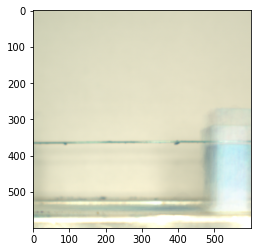

In [1889]:
background = np.mean(nema_kuglica, axis=0).astype(np.uint8)

plt.imshow(background)
plt.show()

### Izdvajanje karakteristika za razlikovanje regularnih i deformisanih kuglica

Prva funkcija izdvaja 8 karakteristika koje su vezane za razliku udaljenosti centra od najudaljenijeg piksela (koji pripada loptici) u određenom pravcu i poluprečnika pravilnog kruga.

In [1519]:
def feature_1(slika, krug, bcg):
    x_c, y_c, r = krug # koordinate centra i poluprecnik kruga

    change_0 = 200 # promena u boji za crvenu komponentu
    change_1 = 200 # promena u boji za zelenu komponentu
    change_2 = 200 # promena u boji za plavu komponentu

    # oduzimanje pozadine od dela slike izvan kruga
    image = slika.copy()
    for i in range(len(image)-100):
        for j in range(len(image[0])-400):
            if (i - y_c)**2 + (j - x_c)**2 > r**2:
                image[i, j] -= bcg[i, j]

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na gore; ako nigde ne dodje do velike promene granice se smanjuju
    up = y_c - 1
    while abs(int(image[up, x_c][0]) - int(image[up+1, x_c][0])) < change_0 and abs(int(image[up, x_c][1]) - int(image[up+1, x_c][1])) < change_1 and abs(int(image[up, x_c][2]) - int(image[up+1, x_c][2])) < change_2:
        up -= 1
        if up == 0:
            up = y_c - 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # visina kruga
    up = y_c - up

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na dole; ako nigde ne dodje do velike promene granice se smanjuju
    down = y_c + 1
    while abs(int(image[down, x_c][0]) - int(image[down-1, x_c][0])) < change_0 and abs(int(image[down, x_c][1]) - int(image[down-1, x_c][1])) < change_1 and abs(int(image[down, x_c][2]) - int(image[down-1, x_c][2])) < change_2:
        down += 1
        if down == len(image):
            down = y_c + 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # dno kruga
    down = down - y_c

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na levo; ako nigde ne dodje do velike promene granice se smanjuju
    left = x_c - 1
    while abs(int(image[y_c, left][0]) - int(image[y_c, left+1][0])) < change_0 and abs(int(image[y_c, left][1]) - int(image[y_c, left+1][1])) < change_1 and abs(int(image[y_c, left][2]) - int(image[y_c, left+1][2])) < change_2:
        left -= 1
        if left == 0:
            left = x_c - 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # levi deo kruga
    left = x_c - left

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na desno; ako nigde ne dodje do velike promene granice se smanjuju
    right = x_c + 1
    while abs(int(image[y_c, right][0]) - int(image[y_c, right-1][0])) < change_0 and abs(int(image[y_c, right][1]) - int(image[y_c, right-1][1])) < change_1 and abs(int(image[y_c, right][2]) - int(image[y_c, right-1][2])) < change_2:
        right += 1
        if right == len(image[0]):
            right = x_c + 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # desni deo kruga
    right = right - x_c

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na gore-desno; ako nigde ne dodje do velike promene granice se smanjuju
    up_right = 1
    while abs(int(image[y_c-up_right, x_c+up_right][0]) - int(image[y_c-up_right+1, x_c+up_right-1][0])) < change_0 and abs(int(image[y_c-up_right, x_c+up_right][1]) - int(image[y_c-up_right+1, x_c+up_right-1][1])) < change_1 and abs(int(image[y_c-up_right, x_c+up_right][2]) - int(image[y_c-up_right+1, x_c+up_right-1][2])) < change_2:
        up_right += 1
        if y_c-up_right == 0 or x_c+up_right == len(image[0]):
            up_right = 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # udaljenost gornjeg-desnog dela kruga
    up_right = int(up_right*np.sqrt(2))

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na gore-levo; ako nigde ne dodje do velike promene granice se smanjuju
    up_left = 1
    while abs(int(image[y_c-up_left, x_c-up_left][0]) - int(image[y_c-up_left+1, x_c-up_left+1][0])) < change_0 and abs(int(image[y_c-up_left, x_c-up_left][1]) - int(image[y_c-up_left+1, x_c-up_left+1][1])) < change_1 and abs(int(image[y_c-up_left, x_c-up_left][2]) - int(image[y_c-up_left+1, x_c-up_left+1][2])) < change_2:
        up_left += 1
        if y_c-up_left == 0 or x_c-up_left == 0:
            up_left = 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # udaljenost gornjeg-levog dela kruga
    up_left = int(up_left*np.sqrt(2))

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na dole-desno; ako nigde ne dodje do velike promene granice se smanjuju
    down_right = 1
    while abs(int(image[y_c+down_right, x_c+down_right][0]) - int(image[y_c+down_right-1, x_c+down_right-1][0])) < change_0 and abs(int(image[y_c+down_right, x_c+down_right][1]) - int(image[y_c+down_right-1, x_c+down_right-1][1])) < change_1 and abs(int(image[y_c+down_right, x_c+down_right][2]) - int(image[y_c+down_right-1, x_c+down_right-1][2])) < change_2:
        down_right += 1
        if y_c+down_right == len(image) or x_c+down_right == len(image[0]):
            down_right = 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # udaljenost donjeg-desnog dela kruga
    down_right = int(down_right*np.sqrt(2))

    # dok su promene na sva tri kanala manje od granica, pomeramo se od centra na dole-levo; ako nigde ne dodje do velike promene granice se smanjuju
    down_left = 1
    while abs(int(image[y_c+down_left, x_c-down_left][0]) - int(image[y_c+down_left-1, x_c-down_left+1][0])) < change_0 and abs(int(image[y_c+down_left, x_c-down_left][1]) - int(image[y_c+down_left-1, x_c-down_left+1][1])) < change_1 and abs(int(image[y_c+down_left, x_c-down_left][2]) - int(image[y_c+down_left-1, x_c-down_left+1][2])) < change_2:
        down_left += 1
        if y_c+down_left == len(image) or x_c-down_left == 0:
            down_left = 1
            change_0, change_1, change_2 = change_0 - 10, change_1 - 10, change_2 - 10
    # udaljenost donjeg-levog dela kruga
    down_left = int(down_left*np.sqrt(2))

    # odredjivanje razlike u vrednostima poluprecnika na raznim stranama i r-om pravilne kruznice
    return abs(up - r), abs(down - r), abs(left - r), abs(right - r), abs(up_right - r), abs(up_left - r), abs(down_right - r), abs(down_left - r)

Druga funkcija služi za izvlačenje 16 karakteristika koje predstavljaju pozicije preseka linija i izdvojenih kontura kruga.

In [1899]:
def feature_2(image):

    # odsecanje desne strane slike jer se na ovom delu nikada ne nalazi kuglica
    image = image[:,:-50]
    # konverzija slike u grayscale
    image_wback = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # pronalazenje dela slike koji sadrzi samo kuglicu, tako sto se posmatra promena vrednosti piksela sa gornje, leve i desne strane slike
    crop_img = image_wback
    for i in range(image_wback.shape[1]-1, 0, -1):
        if(abs(int(image_wback[image_wback.shape[0]//2,:][i])-int(image_wback[image_wback.shape[0]//2,:][i-1])) > 5):
            crop_img = crop_img[:,:i+10]
            break
    for i in range(0, crop_img.shape[1]-1, 1):
        if(abs(int(crop_img[crop_img.shape[0]//2,:][i])-int(crop_img[crop_img.shape[0]//2,:][i+1])) > 5):
            crop_img = crop_img[:,i-10:]
            break
    for i in range(0, crop_img.shape[0]-1, 1):
        if(abs(int(crop_img[:,crop_img.shape[1]//2][i])-int(crop_img[:,crop_img.shape[1]//2][i+1])) > 5):
            crop_img = crop_img[i-10:,:]
            break
    # isecanje dna slike jer se na ovom delu nikada ne nalazi kuglica
    crop_img = crop_img[:-50,:]

    # primena median filtra kako bi se smanjio uticaj suma i dobila slika sa kontinualnijim promenama vrednosti piksela 
    image = cv2.medianBlur(crop_img, 21)
    # primena canny filtra za detekciju ivica
    edges = cv2.Canny(image, 50, 100)
    # primena operacija dilatacije i erozije koje ce spojiti bliske i ukloniti sitne ivice
    edges = cv2.dilate(edges, None, iterations=3)
    edges = cv2.erode(edges, None, iterations=1)

    # nova visina i sirina slike
    width = edges.shape[1]
    height = edges.shape[0]

    # pozicije imaginarnih linija kojima će se odredjivati preseci sa konturama
    lines_pos = [width//8, width//4, -width//8, -width//4, height//8, height//4, -height//8, -height//4]
    intersections_pos = []

    for i in range(8):
        if i < 4:
            line = edges[:, lines_pos[i]]
        else:
            line = edges[lines_pos[i], :]

        indexes = np.where(line == 255) # gde postoji presek
        if indexes[0].size != 0:
            intersections_pos.append(indexes[0][0])     # prvi presek
            intersections_pos.append(indexes[0][-1])    # poslednji presek
        else:
            intersections_pos.append(0)                 # ako nema preseka
            intersections_pos.append(0)

    #plot
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.show()
    
    # svi preseci
    return intersections_pos

Treća funkcija služi za izvlačenje 2 karakteristike koje predstavljaju sumu svih piksela detektovanih kao deo kruga u spoljašnjem prstenu oko same lopte i sumu piksela detektovanih kao pozadina u prstenu unutar kruga.

In [1919]:
def feature_3(slika):

    # pronalazenje kruznice
    kruznica = find_circle(slika)
    x_c, y_c, r = kruznica # koordinate centra i poluprecnik kruga

    # konverzija slike u hsv
    slika_hsv = cv2.cvtColor(slika, cv2.COLOR_BGR2HSV)

    pixels = []
    for i in range(len(slika_hsv)):
        for j in range(len(slika_hsv[0])):
            if (i - y_c)**2 + (j - x_c)**2 < r**2:
                pixels.append(slika_hsv[i, j])

    # srednja vrednost svih piksela unutar kruga     
    mean_pix = np.mean(pixels, axis=0)

    # binarizacija slike na osnovu odredjene srednje vrednosti
    image_binarize = cv2.inRange(slika_hsv[:,:,2], mean_pix[2] - 10, mean_pix[2] + 10)

    # popunjavanje konture, jer je centralni deo loptice uglavnom svetliji zbog blica kamere
    kernel = np.ones((30, 30), np.uint8)
    image_binarize = cv2.morphologyEx(image_binarize, cv2.MORPH_CLOSE, kernel)


    image_array = np.array(image_binarize)
    rows, cols = np.indices(image_array.shape)
    distances_squared = (rows - y_c)**2 + (cols - x_c)**2
    # maska svih piksela koji se nalaze u prstenu unutar kruga r = 50
    in_annulus_mask_1 = (distances_squared < r**2) & (distances_squared > (r - 50)**2) 
    # maska svih piksela koji se nalaze u prstenu van kruga r = 50
    in_annulus_mask_2 = (distances_squared < (r + 50)**2) & (distances_squared > r**2)

    # suma svih crnih piksela u unutrasnjem prstenu i svih belih u spoljasnjem 
    sum_black = np.sum(image_array[in_annulus_mask_1] == 0)
    sum_white = np.sum(image_array[in_annulus_mask_2] == 255)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_binarize, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(slika)
    plt.show()

    return sum_black, sum_white

Četvrta funkcija služi za izvlačenje 6 karakteristika koje predstavljaju odnose broja piksela konture kruga i ivica koji se preklapaju i svih piksela kružnice, piksela koji pripadaju ivicama i svim pikselima u prstenu izvan i unutar kruga; takođe traže se iste 3 karakteristike samo za gornju polovinu kružnice.

In [1925]:
def feature_4(image):
    # primena median filtra kako bi se smanjio uticaj suma i dobila slika sa kontinualnijim promenama vrednosti piksela
    median = cv2.medianBlur(image, 21)
    # primena canny filtra za detekciju ivica
    edges = cv2.Canny(median, 50, 100)
    # primena operacija dilatacije koje ce spojiti bliske ivice
    edges = cv2.dilate(edges, None, iterations=5)

    # pronalazenje kruznice
    circle = list(find_circle(image))
    x, y, r = circle    # koordinate centra i poluprecnik kruga

    # promenljive za broj piksela konture i ivica koji se preklapaju, piksela u prstenu izvan i unutar kruga
    overlap_there, total_there, overlap_out = 0, 0, 0
    total_out, overlap_in, total_in = 0, 0, 0

    # promenljive za broj piksela konture i ivica koji se preklapaju, piksela u prstenu izvan i unutar kruga, samo za gornju polovinu kruga
    # jer se smatra da više grešaka može nastati na donjem delu kruga zbog dodira sa površinom
    overlap_there_y, total_there_y, overlap_out_y = 0, 0, 0
    total_out_y, overlap_in_y, total_in_y = 0, 0, 0

    for i in range(len(edges)):
        for j in range(len(edges[0])):
            if (i - y)**2 + (j - x)**2 < (r + 5)**2 and (i - y)**2 + (j - x)**2 > (r-5)**2:
                overlap_there += edges[i, j]
                total_there += 1
                if i < y:
                    overlap_there_y += edges[i, j]
                    total_there_y += 1
            elif (i - y)**2 + (j - x)**2 > (r + 10)**2 and (i - y)**2 + (j - x)**2 < (r + 20)**2:
                overlap_out += edges[i, j]
                total_out += 1
                if i < y:
                    overlap_out_y += edges[i, j]
                    total_out_y += 1
            elif (i - y)**2 + (j - x)**2 < (r-5)**2 and (i - y)**2 + (j - x)**2 > (r - 15)**2:
                overlap_in += edges[i, j]
                total_in += 1
                if i < y:
                    overlap_in_y += edges[i, j]
                    total_in_y += 1

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(edges, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

    # vracanje odnosa     
    return overlap_there / (255*total_there), overlap_out / (255*total_out), overlap_in / (255*total_in), overlap_there_y / (255*total_there_y), overlap_out_y / (255*total_out_y), overlap_in_y / (255*total_in_y)

### Analiza svih karakteristika

##### Analiza funkcije_1

Karakteristike prve kuglice: (3, 8, 1, 0, 1, 0, 1, 1)
Karakteristike druge kuglice: (24, 5, 1, 15, 25, 0, 2, 0)


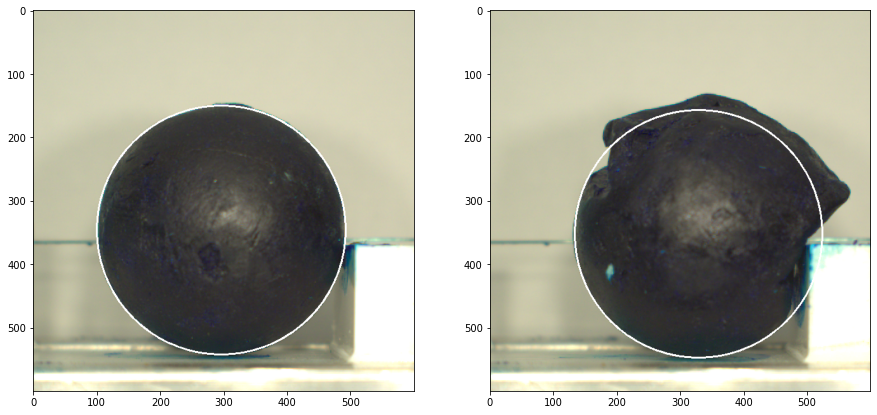

In [1898]:
kuglica_1 = ima_kuglica[1].copy()
circle_1 = list(find_circle(kuglica_1))
f1 = feature_1(kuglica_1, circle_1, background)
print("Karakteristike prve kuglice:", f1)

kuglica_2 = ima_kuglica[4].copy()
circle_2 = list(find_circle(kuglica_2))
f1 = feature_1(kuglica_2, circle_2, background)
print("Karakteristike druge kuglice:", f1)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
cv2.circle(kuglica_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(kuglica_1, cmap='gray')
plt.subplot(1, 2, 2)
cv2.circle(kuglica_2, (circle_2[0], circle_2[1]), circle_2[2], (255, 255, 255), 2)
plt.imshow(kuglica_2, cmap='gray')
plt.show()

Sa prve slike vidi se da je kuglica regularna i iz karakteristika se očitava da nema velikih odstupanja ivica kuglice od opisane kružnice. Suprotno tome, sa druge slike se vidi da je kuglica neregularna, a sa karakteristika očitava vidno odstupanje gornje tačke od kružnice, kao i desne i gornje-desne tačke.

##### Analiza funkcije_2

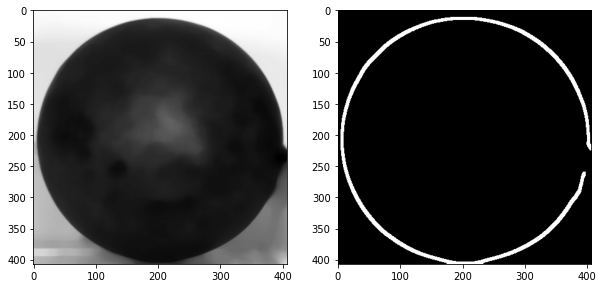

Karakteristike slike: [78, 336, 36, 378, 79, 337, 37, 379, 79, 325, 34, 372, 69, 338, 29, 379]


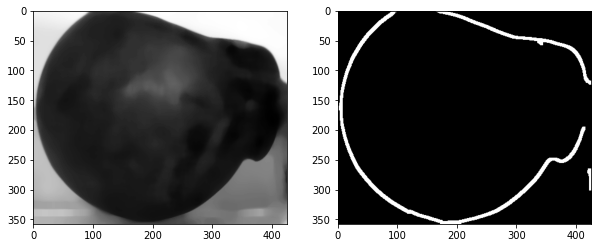

Karakteristike slike: [33, 294, 327, 334, 55, 255, 45, 299, 43, 313, 17, 411, 74, 304, 32, 425]


In [1901]:
image = ima_kuglica[2].copy()
f2 = feature_2(image)
print("Karakteristike slike:", f2)

image = ima_kuglica[0].copy()
f2 = feature_2(image)
print("Karakteristike slike:", f2)

Na slikama iznad su prikazani primeri izdvojenih ivica (kontura) regularne i deformisane kuglice. Po dve koordinate ivica na visinama h/8, h/4, -h/8, -h/4, kao i širinama w/8, w/4, -w/8, -w/4, predstavljaju odgovarajuće izvučene karakteristike. Kod pravilne loptice vidimo simetričnu pojavu vrednosti, dok kod deformisane uočavamo veća odstupanja. Iz toga proizilazi zaključak da se provera simetričnosti ovih vrednosti može uzeti kao bolja karakteristika (što će u kasnijim koracima biti odrađeno i provereno).

##### Analiza funkcije_3

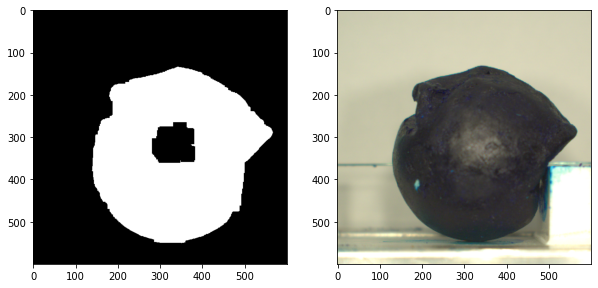

Karakteristike slike: (4006, 10760)


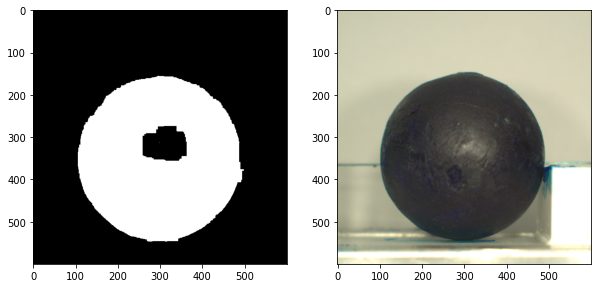

Karakteristike slike: (4540, 932)


In [1923]:
f3 = feature_3(ima_kuglica[4])
print("Karakteristike slike:", f3)

f3 = feature_3(ima_kuglica[1])
print("Karakteristike slike:", f3)

Suma belih piksela u prstenu izvan slike za deformisanu kuglicu vidno je veća nego kod normalne, a suma crnih piksela u prstenu unutra je slična, jer se kod deformisane loptice javljaju samo izbočine. Znači suma belih piksela treba registrovati izbočine kod loptica, a suma crnih ulegnuća.   
Vidimo da postoji neki broj crnih piksela koji je svakako prebrojan iako se na slici ne detektuju nikakva ulegnuća, i to se dešava zbog ne toliko idealne površi lopte.

##### Analiza funkcije_4

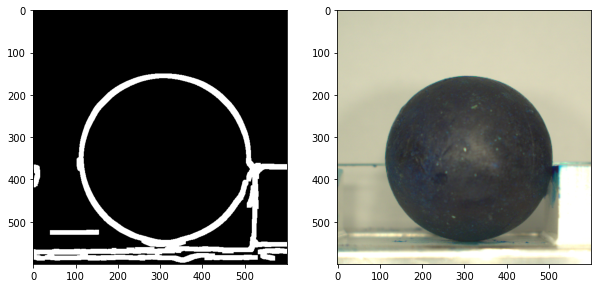

Karakteristike slike: (0.8724673202614379, 0.1662108781525372, 0.10507246376811594, 0.9181803305514645, 0.05842081241442264, 0.10938310005184033)


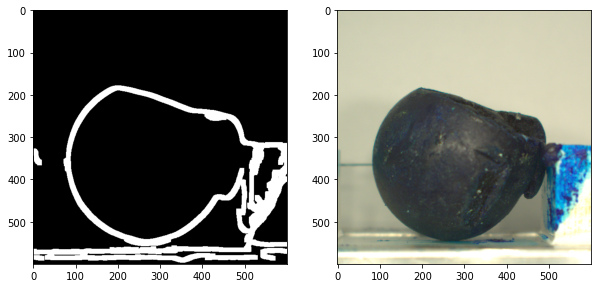

Karakteristike slike: (0.6368116927260367, 0.07666352793471437, 0.2600071479628306, 0.451063829787234, 0.04117554612604118, 0.2027921961696796)


In [1926]:
f4 = feature_4(ima_kuglica[2])
print("Karakteristike slike:", f4)  
f4 = feature_4(ima_kuglica[0])
print("Karakteristike slike:", f4)

Kod regularne kuglice, poklapanje ivica i opisane kružnice rezultuje vrednosti bližoj 1, dok je kod deformisane kuglice ta vrednost manja. Detektovanje ivica u prstenu malo izvan kružnice i malo unutar su vrednosti bliže 0 kod regularnih kuglica, i obrnuto kod deformisanih. Ukoliko se osmotre iste karakteristike samo na gornjoj polovini lopte, uočava se još drastičnija razlika između različitih klasa, jer se deformitet lakše uočava u tom predelu, zbog uticaja podloge i zida u donjoj polovini slike.

##### Učitavanje svih karakteristika

Računanje svih karakteristika i manipulacija nad njima rađena je iz više delova, a kako ponovno pokretanje ćelija zahteva i do par sati, ostavljen je sledeći kod.

In [1530]:
# karakteristike dobijene prvim trima funkcijama 
ficeri = []
for kuglica in ima_kuglica:
    slika_kug = kuglica.copy()
    circle = list(find_circle(slika_kug))
    ficer1 = feature_1(kuglica, circle, background)
    ficer2 = feature_2(kuglica)
    ficer3 = feature_3(kuglica)
    # nadovezivanje 
    ficer = np.concatenate((ficer1, ficer2, ficer3))
    ficeri.append(ficer)

In [1789]:
# karakteristike dobijene cetvrtom funkcijom
ficeri_4 = []
for kuglica in ima_kuglica:
    ficer4 = feature_4(kuglica)
    ficeri_4.append(ficer4)

ficeri_4 = [list(i) for i in ficeri_4]

In [1929]:
# formiranje dataframe-a od karakteristika 4. funkcije
ficeri_4_pd = pd.DataFrame(ficeri_4, columns=['overlap_there', 'overlap_out', 'overlap_in', 'overlap_there_y', 'overlap_out_y', 'overlap_in_y'])
# formiranje dataframe-a od karakteristika 1., 2. i 3. funkcije
ficeri_pd = pd.DataFrame(ficeri, columns=['up', 'down', 'left', 'right', 'upr', 'upl', 'dr', 'dl', '8w1', '8w2', '4w1', '4w2', '-8w1', '-8w2', '-4w1', '-4w2', '8h1', '8h2', '4h1', '4h2', '-8h1', '-8h2', '-4h1', '-4h2', 'sum_b', 'sum_w'])

In [1930]:
# nadovezivanje svih karakteristika
ficeri_pd = pd.concat([ficeri_pd, ficeri_4_pd], axis=1)
# dodavanje labela
ficeri_pd['label'] = ima_kuglica_labele

Kako što je pomenuto u analizi funkcije_2, u ćeliji ispod su formirane nove karakteristike koje proveravaju simetričnost preseka imaginarnih linija i ivica kuglice.

In [1931]:
ficeri_pd['8w1_diff'] = abs(ficeri_pd['8w1'] - ficeri_pd['-8w1'])
ficeri_pd['8w2_diff'] = abs(ficeri_pd['8w2'] - ficeri_pd['-8w2'])
ficeri_pd['4w1_diff'] = abs(ficeri_pd['4w1'] - ficeri_pd['-4w1'])
ficeri_pd['4w2_diff'] = abs(ficeri_pd['4w2'] - ficeri_pd['-4w2'])
ficeri_pd['8h1_diff'] = abs(ficeri_pd['8h1'] - ficeri_pd['-8h1'])
ficeri_pd['8h2_diff'] = abs(ficeri_pd['8h2'] - ficeri_pd['-8h2'])
ficeri_pd['4h1_diff'] = abs(ficeri_pd['4h1'] - ficeri_pd['-4h1'])
ficeri_pd['4h2_diff'] = abs(ficeri_pd['4h2'] - ficeri_pd['-4h2'])

Radi provere korisnosti fičera posmatrane su njihove korelacije sa labelama.

In [1937]:
correl = ficeri_pd.corr()['label']
correl_pd = pd.DataFrame(correl)

Karakteristike je lakše posmatrati nakon sortiranja po korelaciji sa labelom.

In [1938]:
correl = correl.sort_values(ascending=False).drop('label')
correl

8h1_diff           0.326713
overlap_out        0.305106
4w1_diff           0.265823
-4h1               0.242466
4h1_diff           0.240913
sum_w              0.237900
overlap_in         0.227370
4w2_diff           0.220531
dl                 0.219336
up                 0.206825
right              0.205755
overlap_in_y       0.192542
left               0.192233
4w1                0.187995
8w1_diff           0.185474
upr                0.175974
4h1                0.175579
overlap_out_y      0.173963
4h2_diff           0.161391
upl                0.148702
dr                 0.122354
down               0.119361
sum_b              0.113538
8w1                0.113456
8w2_diff           0.103974
8h2_diff           0.088760
8h2                0.083563
-8h1               0.081436
8h1                0.073948
8w2                0.066931
-8w2               0.060523
-8h2               0.056287
-4w1               0.050153
-4h2               0.036560
4h2                0.009396
4w2               -0

Izdvojene su karakteristike sa apsolutnom vrednosti korelacije većom od 0.1, i samo one su dalje korišćene za klasifikaciju.

In [1939]:
best_cor = list(correl[abs(correl) > 0.1].index)
best_cor

['8h1_diff',
 'overlap_out',
 '4w1_diff',
 '-4h1',
 '4h1_diff',
 'sum_w',
 'overlap_in',
 '4w2_diff',
 'dl',
 'up',
 'right',
 'overlap_in_y',
 'left',
 '4w1',
 '8w1_diff',
 'upr',
 '4h1',
 'overlap_out_y',
 '4h2_diff',
 'upl',
 'dr',
 'down',
 'sum_b',
 '8w1',
 '8w2_diff',
 '-4w2',
 '-8w1',
 'overlap_there_y',
 'overlap_there']

In [1945]:
ficeri_sub = ficeri_pd[best_cor]

### Klasifikacija na regularne i deformisane kuglice

Da bismo izvršili adekvatnu analizu performansi klasifikacije, korišćena je krosvalidacija. 

In [1977]:
acc_rf = [] # lista za cuvanje tacnosti

for i in range(10): # 10 puta 
    # podela podataka na trening i test skup
    X_train, X_test, y_train, y_test = train_test_split(ficeri_sub, ima_kuglica_labele, test_size=0.2, shuffle=True, random_state=42)

    # kreiranje modela
    model = RandomForestClassifier(n_estimators=100, max_depth=11)
    # treniranje modela
    model.fit(X_train, y_train)
    # predvidjanje
    y_pred = model.predict(X_test)

    # tacnost
    print(accuracy_score(y_test, y_pred))
    acc_rf.append(accuracy_score(y_test, y_pred))

# prosecna tacnost
print('Mean accuracy rf: ', np.mean(acc_rf))

0.9090909090909091
0.9090909090909091
0.8727272727272727
0.8727272727272727
0.8909090909090909
0.9454545454545454
0.9090909090909091
0.8909090909090909
0.8909090909090909
0.9272727272727272
Mean accuracy rf:  0.9018181818181817


In [1980]:
np.std(acc_rf)

0.021818181818181823

Tačnost klasifikacije iznosi 90.2%, sa standoardnom devijacijom od 2.2%.

Pokrenut je jedan test radi analize matrice konfuzije.

0.8909090909090909


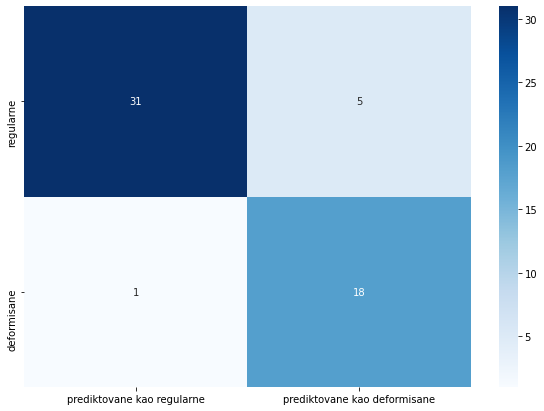

In [2004]:
# podela na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(ficeri_sub, ima_kuglica_labele, test_size=0.2, random_state=42, shuffle=True)

# kreiranje modela
clf = RandomForestClassifier(n_estimators=100, max_depth=11)
# treniranje modela
clf.fit(X_train, y_train)

# predvidjanje
y_pred = clf.predict(X_test)
# tacnost
print(accuracy_score(y_test, y_pred))

# matrica konfuzije
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['regularne', 'deformisane'], columns=['prediktovane kao regularne', 'prediktovane kao deformisane'])

plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()

Na matrici konfuzije vidimo da se više regularnih kuglica prediktuje kao deformisane nego obrnuto.      
Izabrani model - šuma odlučivanja, dao je najbolje rezultate (u poređenju sa KNNom, SVMom i DTjem); ali i pored toga, on je prilično otporan na preobučavanje i to je još jedan razlog njegovog izbora. Prilikom svake podele na trening i test set, podaci su mešani.     
Labeliranje svih podataka i proširivanje baze jedan je od načina za potvrđivanje i bolju generalizaciju rezultata.

### Primeri loše i dobro klasifikovanih kuglica

In [2024]:
# indeksi loše klasifikovanih slika
missclassified = [i for i, (label, pred) in enumerate(zip(y_test, y_pred)) if label != pred]
missclassified = list(X_test.iloc[missclassified].index)
missclassified

[125, 114, 124, 25, 86, 157]

#### Prikaz loše klasifikovanih kuglica

##### Prva loše klasifikovana kuglica

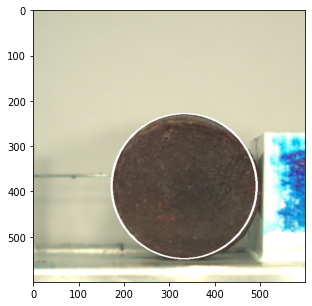

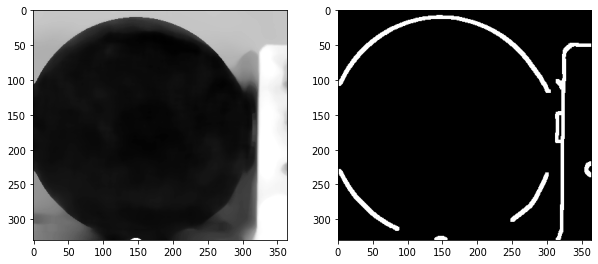

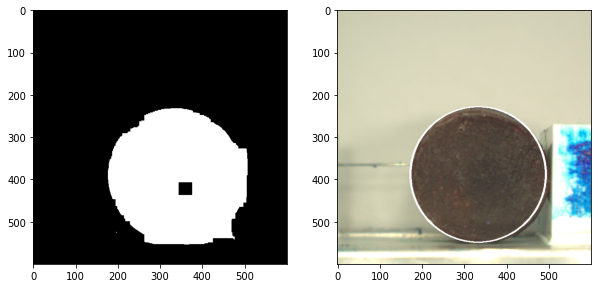

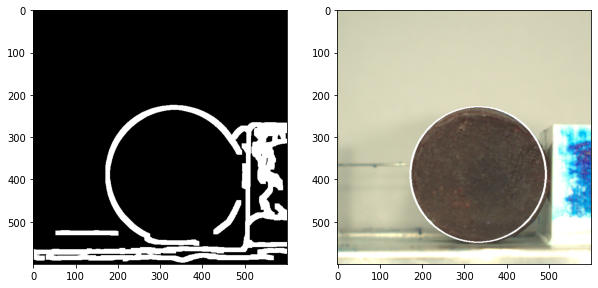

In [2029]:
slika_1 = ima_kuglica[missclassified[0]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

Prva kuglica je labelirana kao regularna, a klasifikovana kao deformisana. Ako pogledamo slike prilikom izvlačenja različitih karakteristika, vidimo da se ne detektuju lepo sve ivice loptice na drugoj i poslednjoj slici, kao i da se detektuje deo podloge i zida na trećoj. Smatra se da se ove greške odražavaju na neke od najbitnijih karakteristika i samim tim na kasniju klasifikaciju.

##### Druga, treća i šesta loše klasifikovana kuglica

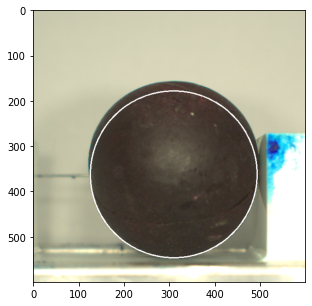

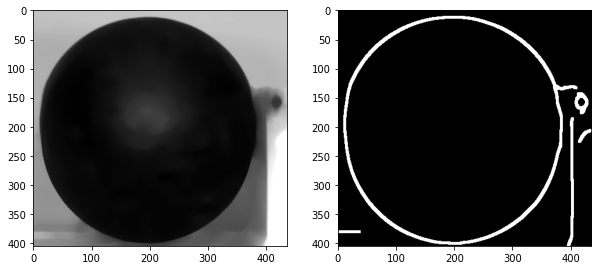

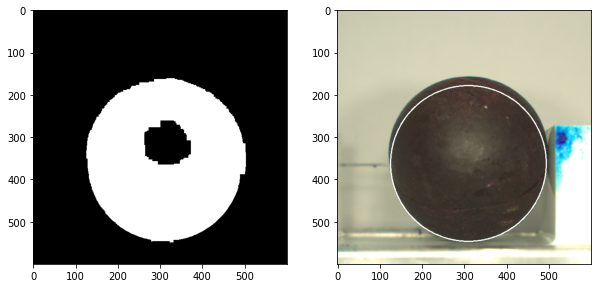

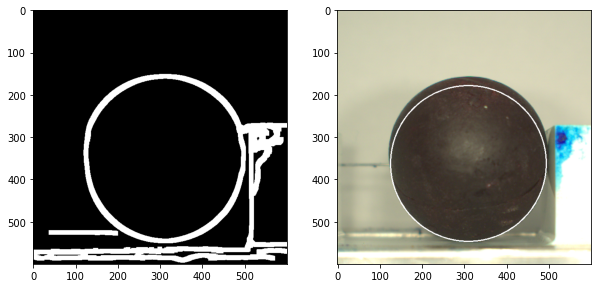

In [2034]:
slika_1 = ima_kuglica[missclassified[2]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

Ove kuglice imaju isti problem, a to je da su jajastog oblika, što dovodi do loših karakteristika prikom računanja broja piksela ivica koji se preklapaju sa opisanom kružnicom i broja piksela koji pripadaju ivicama u prstenima izvan i unutar nje. 

##### Četvrta loše klasifikovana kuglica

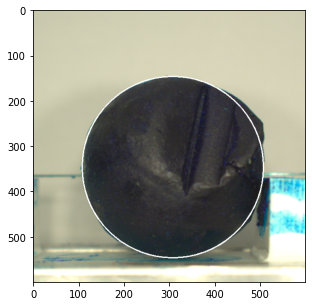

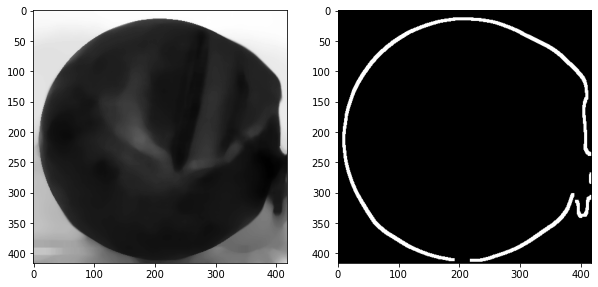

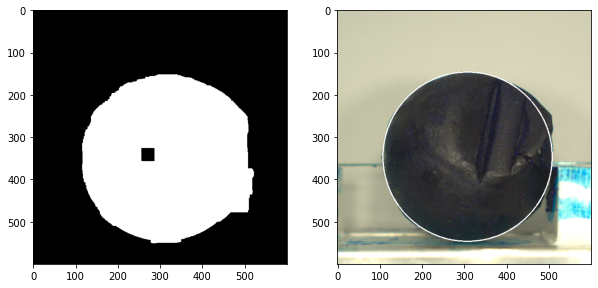

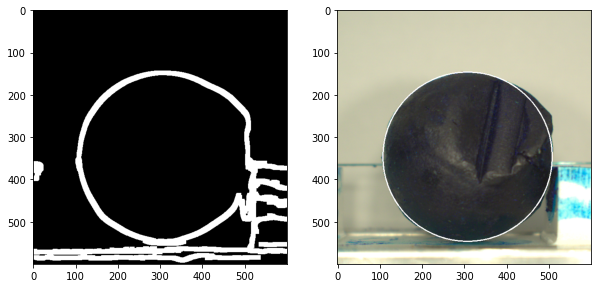

In [2031]:
slika_1 = ima_kuglica[missclassified[3]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

Samo je jedna deformisana kuglica klasifikovana kao dobra, i taj problem ogleda se u deformaciji u gornjem desnom uglu, koja je dovoljno velika da ne bude zakačena spoljašnjim prstenom, a dovoljno mala da ne poremeti previše broj piksela ivice i kružnice koji se poklapaju. 

##### Peta loše klasifikovana kuglica

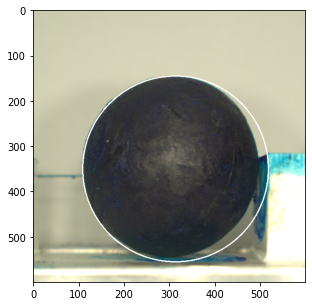

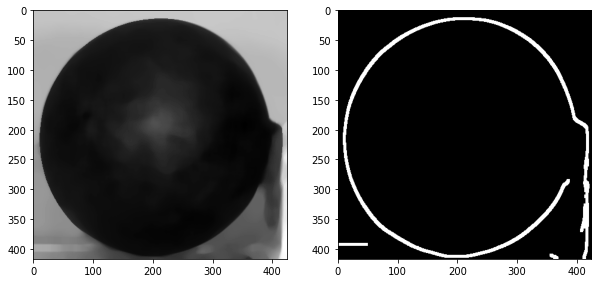

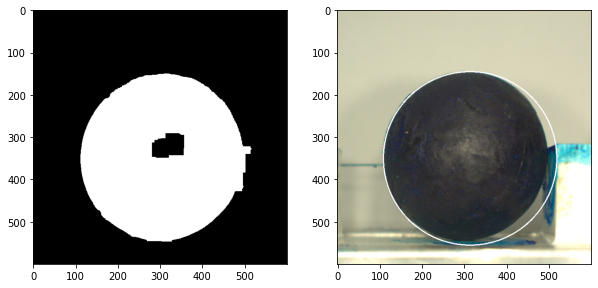

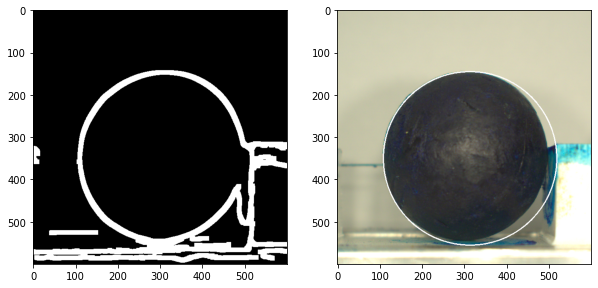

In [2032]:
slika_1 = ima_kuglica[missclassified[4]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

Problem pri klasifikaciji ove kuglice dogodio se zbog pogrešno određene opisane kružnice - greška ugrađene funkcije. 

#### Prikaz dobro klasifikovanih kuglica

In [2041]:
# indeksi dobro klasifikovanih slika
okay = [i for i, (label, pred) in enumerate(zip(y_test, y_pred)) if label == pred]
okay = list(X_test.iloc[okay].index)

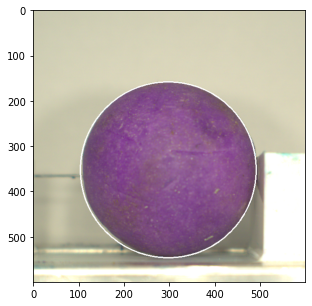

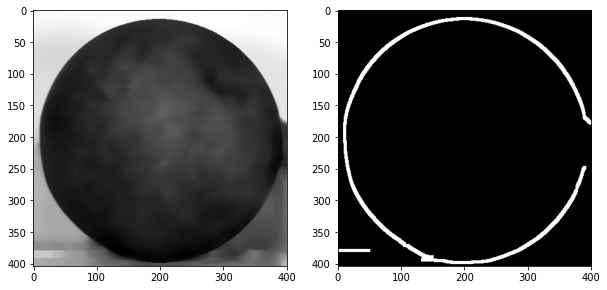

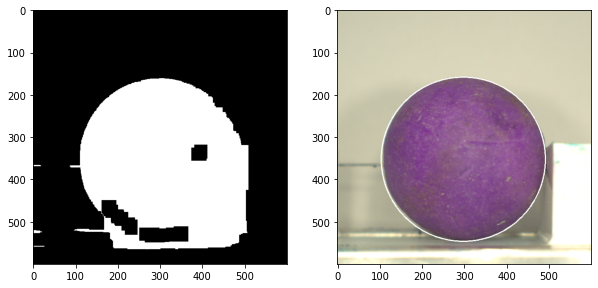

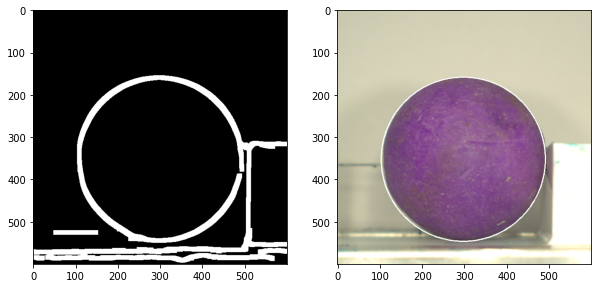

In [2050]:
slika_1 = ima_kuglica[okay[8]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

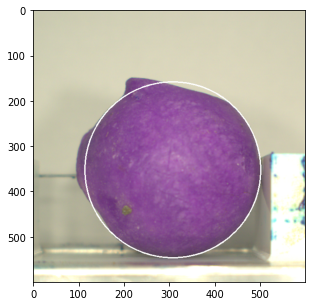

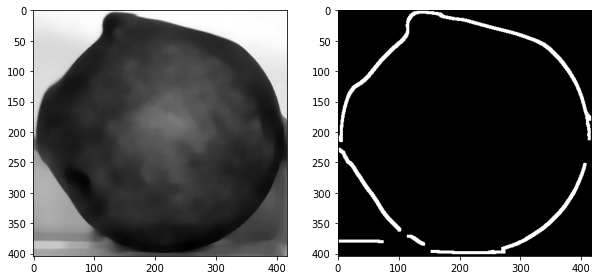

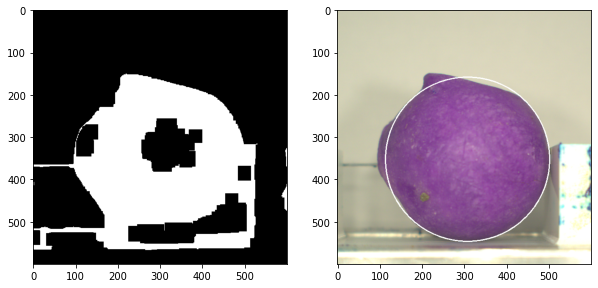

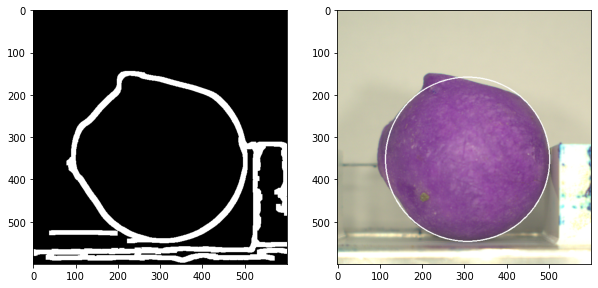

In [2044]:
slika_1 = ima_kuglica[okay[2]]

circle_1 = list(find_circle(slika_1))
f1 = feature_1(slika_1, circle_1, background)
plt.figure(figsize=(5, 5))
cv2.circle(slika_1, (circle_1[0], circle_1[1]), circle_1[2], (255, 255, 255), 2)
plt.imshow(slika_1, cmap='gray')
plt.show()
f2 = feature_2(slika_1)
f3 = feature_3(slika_1)
f4 = feature_4(slika_1)

Na slikama su prikazana dva primera dobro klasifikovanih kuglica (jedna regularna i jedna deformisana). Iz procesa izvlačenja karakteristika vidimo da važi sledeće:    
regularna kuglica vs deformisana kuglica (najbitnije razlike na slikama i u karakteristikama):         
1. simetrične tačke preseka sa imaginarnim ravnima; nema 
2. ivice se skroz poklapaju sa kružnicom i u prstenima izvan i unutra nema belih piksela; uočavaju se i ispupčenja i udubljenja